# House price analysis - version 4 
My notebook for [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels?userId=1075113) competition

## Credit: Many thanks to:
- Pedro Marcelino [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

- Sergei Neviadomski [How to get to TOP 25% with Simple Model (sklearn)](https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn)

- juliencsA [study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
- BradenFitz-Gerald [RandomForestRegressor](https://www.kaggle.com/dfitzgerald3/randomforestregressor)
- Tanner Carbonati [Detailed Data Analysis & Ensemble Modeling] (https://www.kaggle.com/tannercarbonati/detailed-data-analysis-ensemble-modeling/comments/notebook)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBRegressor
from math import sqrt
from scipy import stats
import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load and combine data

In [4]:
# Load data. Download from:https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [5]:
# Combine data
# Initial features
o_features = eval_data.columns.values
label = 'SalePrice'
# Store eval_id
eval_data_id = eval_data['Id']
#Seperate input and label from train_data
input_data = train_data[o_features]
target = train_data[label]
#input_data.head(5)
#Combine train + eval data
combine_data = pd.concat([input_data, eval_data], keys=['train','eval'])
combine_data.head(5)
data = combine_data


# Fill NaN values

### Check NaN columns

In [6]:
def check_null_data():
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [7]:
miss_data_cols = check_null_data()
print(miss_data_cols)

              Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF1        1  0.000343
Exterior1st       1  0.000343
Exterior2nd       1  0.000343
BsmtFinSF2        1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
SaleType          1  0.000343
Electrical        1  0.000343
KitchenQual       1  0.000343
GarageArea

### PoolQC

train  0    NaN
       1    NaN
       2    NaN
       3    NaN
       4    NaN
Name: PoolQC, dtype: object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cbe9c5400>], dtype=object)

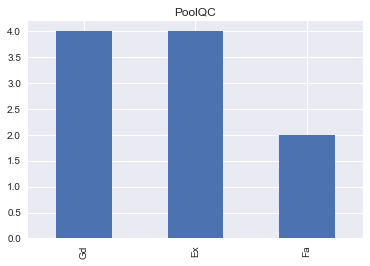

In [8]:
# PoolQC
col = 'PoolQC'
print(data[col].head(5))
data[col].value_counts().plot(kind='bar', subplots=True)

In [9]:
# Check NaN PoolQC with PoolArea
combine_data[['Id', col, 'PoolArea']][(combine_data[col].isnull()) & (combine_data['PoolArea']>0)]

Id PoolQC  PoolArea
eval 960   2421    NaN       368
     1043  2504    NaN       444
     1139  2600    NaN       561

In [10]:
#Check AVG PoolArea by PoolQC
combine_data[[col, 'PoolArea']].groupby(col).mean()

,PoolArea
PoolQC,
Ex,359.75
Fa,583.50
Gd,648.50


In [11]:
# Filling special value of PoolQC
data.loc[data['Id'] == 2421, col] = 'Ex'
data.loc[data['Id'] == 2504, col] = 'Ex'
data.loc[data['Id'] == 2600, col] = 'Fa'
data[col].fillna('None', inplace=True)

- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition

### GarageYrBlt

In [12]:
# Check GarageYrBlt & YearBuilt
col = 'GarageYrBlt'
print("Number of same YearBuild=", col, ":", len(data[data[col] == data['YearBuilt']]))

Number of same YearBuild= GarageYrBlt : 2216


In [13]:
# Update GarageYrBlt = YearBuilt
data.loc[data[col].isnull(), col] = data.loc[data[col].isnull(),'YearBuilt']
data[['Id', col,'YearBuilt']].loc[data['Id'] == 40]

,,Id,GarageYrBlt,YearBuilt
train,39,40,1955.0,1955


### Garage columns

In [14]:
cols = ['GarageArea', 'GarageCars', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType']
for col in cols:
    print(col,":", data[col].dtype)
    if data[col].dtype == 'object':
        data[col] = 'None'
    else:
        data[col] = 0
data[cols].head(10)        

GarageArea : float64
GarageCars : float64
GarageQual : object
GarageFinish : object
GarageCond : object
GarageType : object


GarageArea  GarageCars GarageQual GarageFinish GarageCond GarageType
train 0           0           0       None         None       None       None
      1           0           0       None         None       None       None
      2           0           0       None         None       None       None
      3           0           0       None         None       None       None
      4           0           0       None         None       None       None
      5           0           0       None         None       None       None
      6           0           0       None         None       None       None
      7           0           0       None         None       None       None
      8           0           0       None         None       None       None
      9           0           0       None         None       None       None

### KitchenQual: Kitchen quality

Number of null value for: KitchenQual : 1


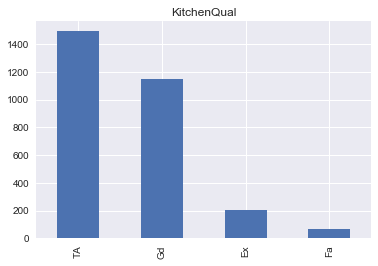

In [15]:
col = 'KitchenQual'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'TA'

### Electrical: Electrical system

Number of null value for: Electrical : 1


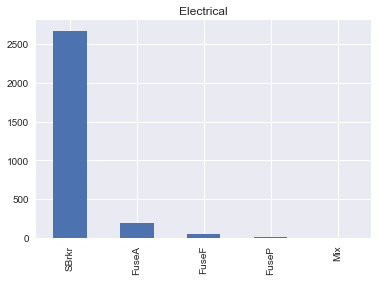

In [16]:
col = 'Electrical'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'SBrkr'

- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms

In [17]:
# Select cols with name match *Bsmt*
all_cols = data.columns.values
r = re.compile("Bsmt")
cols = list(filter(r.search, all_cols))
cols

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [18]:
# Check null for *Bsmt*
null_data = data[cols].isnull()
total = null_data.sum().sort_values(ascending=False)
total[total>0]

BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
BsmtHalfBath     2
BsmtFullBath     2
TotalBsmtSF      1
BsmtUnfSF        1
BsmtFinSF2       1
BsmtFinSF1       1
dtype: int64

Number of null value for: BsmtExposure : 82


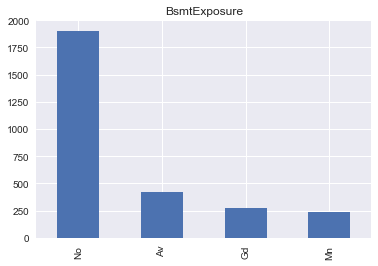

In [19]:
# BsmtExposure
col = 'BsmtExposure'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'No'

In [20]:
# Other Bsmt cols
for col in cols:
    print(col, ":", data[col].dtype)
    if data[col].dtype == 'object':
        data.loc[data[col].isnull(), col] = 'None'
    else:
        data.loc[data[col].isnull(), col] = 0

BsmtQual : object
BsmtCond : object
BsmtExposure : object
BsmtFinType1 : object
BsmtFinSF1 : float64
BsmtFinType2 : object
BsmtFinSF2 : float64
BsmtUnfSF : float64
TotalBsmtSF : float64
BsmtFullBath : float64
BsmtHalfBath : float64


- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)

Number of null value for: Exterior1st : 1


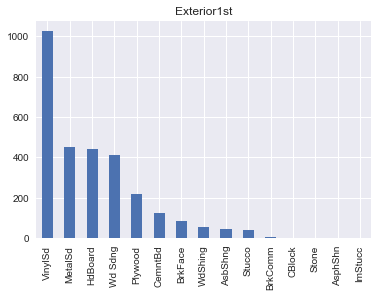

In [21]:
# Check for null Exterior1st
col ='Exterior1st'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'None'

Number of null value for: Exterior2nd : 1


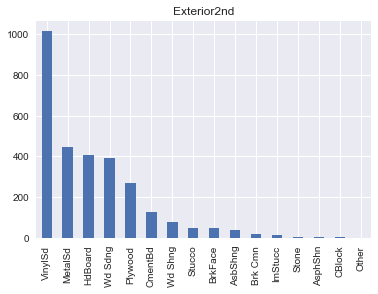

In [22]:
# Check for null Exterior2nd
col ='Exterior2nd'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'None'

### SaleType: Type of sale

In [23]:
# Check for null SaleType
col ='SaleType'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
print(data.loc[data[col].isnull(), [col, 'SaleCondition']])
data.loc[data[col].isnull(), col] = 'WD'
#data.loc[data[col].isnull(), col] = 'None'

Number of null value for: SaleType : 1
          SaleType SaleCondition
eval 1029      NaN        Normal


In [24]:
# Use crosstab to see frequency between SaleType and SaleCondition
pd.crosstab(data['SaleCondition'], data[col])

SaleType,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
SaleCondition,,,,,,,,,
Abnorml,46,1,0,3,2,0,0,5,133
AdjLand,0,0,0,0,0,0,0,0,12
Alloca,0,0,0,0,0,0,0,0,24
Family,2,1,0,1,2,1,0,1,38
Normal,39,10,4,21,5,7,0,1,2315
Partial,0,0,1,1,0,0,239,0,4


### Functional: Home functionality rating

Number of null value for: Functional : 2


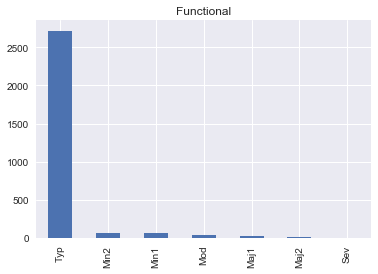

In [25]:
# Check for null Functional
col ='Functional'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'Typ'

### Utilities: Type of utilities available

Number of null value for: Utilities : 2


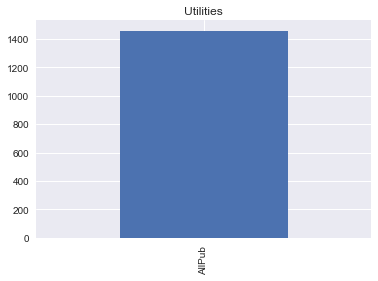

In [26]:
# Check for null Functional
col ='Utilities'
#null_data = data[data[col].isnull()]
#null_data = train_data[train_data[col].isnull()]
null_data = eval_data[eval_data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
eval_data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'AllPub'

### MSZoning: The general zoning classification

Number of null value for: MSZoning : 4


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cbc032ef0>], dtype=object)

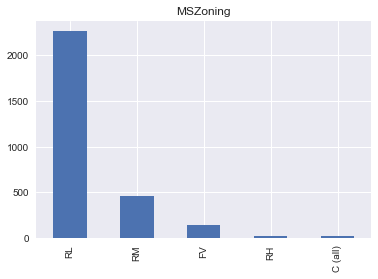

In [27]:
# Check for null MSZoning
col ='MSZoning'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)

In [28]:
# Check relationship between MSZoning and MSSubClass for NaN values
data.loc[data[col].isnull(), ['Id', col, 'MSSubClass']]

Id MSZoning  MSSubClass
eval 455   1916      NaN          30
     756   2217      NaN          20
     790   2251      NaN          70
     1444  2905      NaN          20

In [29]:
# Use crosstab to see frequency between MSZoning and MSSubClass
pd.crosstab(data[col], data['MSSubClass'])

MSSubClass,20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190
MSZoning,,,,,,,,,,,,,,,,
C (all),3,8,0,0,7,0,4,0,0,0,0,0,0,0,0,3
FV,34,0,0,0,0,43,0,0,0,0,0,19,0,43,0,0
RH,4,2,0,1,2,0,3,0,0,0,4,6,0,0,0,4
RL,1016,61,4,6,159,529,57,9,115,47,92,117,1,21,0,31
RM,20,67,2,11,119,3,63,14,3,1,13,40,0,64,17,23


In [30]:
# Fill NaN for MSZoning
data.loc[(data['Id'] == 2217) | (data['Id'] == 2905) , col] = 'RL'
data.loc[data['Id'] == 1916, col] = 'RM'
data.loc[data['Id'] == 2251, col] = 'RM'

- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet

In [31]:
# Check for null MasVnrType
col = 'MasVnrType'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data.loc[data[col].isnull(), col] = 'None'

Number of null value for: MasVnrType : 24


In [32]:
# Check for null MasVnrType
col = 'MasVnrArea'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data.loc[data[col].isnull(), col] = 0

Number of null value for: MasVnrArea : 23


### LotFrontage: Linear feet of street connected to property

In [33]:
# Check for null LotFrontage
col = 'LotFrontage'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].fillna(data[col].mean(), inplace=True)

Number of null value for: LotFrontage : 486


- Fence: Fence quality
- MiscFeature

In [34]:
col = 'Fence'
data[col].fillna('None', inplace=True)

In [35]:
col = 'MiscFeature'
data[col].fillna('None', inplace=True)

- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality

In [36]:
col = 'FireplaceQu'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
# Check relationship between FireplaceQu and Fireplaces for NaN values
data.loc[data[col].isnull(), ['Id', col, 'Fireplaces']][:5]
data[col].fillna('None', inplace=True)

Number of null value for: FireplaceQu : 1420


### Alley: Type of alley access

In [37]:
col = 'Alley'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].fillna('None', inplace=True)

Number of null value for: Alley : 2721


In [38]:
## Check if any missing value remains

In [39]:
miss_data_cols = check_null_data()
print(miss_data_cols)

Empty DataFrame
Columns: [Total, Percent]
Index: []
[]


# Transform object data

In [40]:
object_data = combine_data.select_dtypes(include=['object'])
object_cols = object_data.columns.values
object_data.head(10)

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
train 0       RL   Pave  None      Reg         Lvl    AllPub    Inside   
      1       RL   Pave  None      Reg         Lvl    AllPub       FR2   
      2       RL   Pave  None      IR1         Lvl    AllPub    Inside   
      3       RL   Pave  None      IR1         Lvl    AllPub    Corner   
      4       RL   Pave  None      IR1         Lvl    AllPub       FR2   
      5       RL   Pave  None      IR1         Lvl    AllPub    Inside   
      6       RL   Pave  None      Reg         Lvl    AllPub    Inside   
      7       RL   Pave  None      IR1         Lvl    AllPub    Corner   
      8       RM   Pave  None      Reg         Lvl    AllPub    Inside   
      9       RL   Pave  None      Reg         Lvl    AllPub    Corner   

        LandSlope Neighborhood Condition1      ...      GarageType  \
train 0       Gtl      CollgCr       Norm      ...            None   
      1       Gtl      Veenker      Feedr      ...            None   
      2       Gtl      CollgCr       Norm      ...            None   
      3       Gtl      Crawfor       Norm      ...            None   
      4       Gtl      NoRidge       Norm      ...            None   
      5       Gtl      Mitchel       Norm      ...            None   
      6       Gtl      Somerst       Norm      ...            None   
      7       Gtl       NWAmes       PosN      ...            None   
      8       Gtl      OldTown     Artery      ...            None   
      9       Gtl      BrkSide     Artery      ...            None   

        GarageFinish GarageQual GarageCond PavedDrive PoolQC  Fence  \
train 0         None       None       None          Y   None   None   
      1         None       None       None          Y   None   None   
      2         None       None       None          Y   None   None   
      3         None       None       None          Y   None   None   
      4         None       None       None          Y   None   None   
      5         None       None       None          Y   None  MnPrv   
      6         None       None       None          Y   None   None   
      7         None       None       None          Y   None   None   
      8         None       None       None          Y   None   None   
      9         None       None       None          Y   None   None   

        MiscFeature SaleType SaleCondition  
train 0        None       WD        Normal  
      1        None       WD        Normal  
      2        None       WD        Normal  
      3        None       WD       Abnorml  
      4        None       WD        Normal  
      5        Shed       WD        Normal  
      6        None       WD        Normal  
      7        Shed       WD        Normal  
      8        None       WD       Abnorml  
      9        None       WD        Normal  

[10 rows x 43 columns]

### Tranform category data based on mean of SalePrice

In [57]:
col = 'BsmtExposure'
#data[[col, label]].groupby(label).mean()
data_st = train_data[[col, label]].groupby(col,as_index=False).mean().sort_values(label).reset_index()
data_st[:5]

,index,BsmtExposure,SalePrice
0,3,No,165652.295908
1,2,Mn,192789.657895
2,0,Av,206643.420814
3,1,Gd,257689.805970


In [58]:
data_sr = pd.Series(data_st.index.values, index=data_st[col])
data_dict = data_sr.to_dict()
data_dict

{'Av': 2, 'Gd': 3, 'Mn': 1, 'No': 0}

In [43]:
object_data = data.select_dtypes(include=['object'])
object_features = object_data.columns.values
for col in object_features:
            # get numeric value of col based on mean of label
            data_st = train_data[[col, label]].groupby(col, as_index=False).mean()
            data_sr = pd.Series(data_st.index.values, index=data_st[col])
            data_dict = data_sr.to_dict()
            data_tf = data[col].map(data_dict)
            data[col].update(data_tf)
            # Update None = 0
            data.loc[data[col] == 'None', col] = 0
        

In [44]:
data[object_features][:20]

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
train 0         3      1     0        3           3         0         4   
      1         3      1     0        3           3         0         2   
      2         3      1     0        0           3         0         4   
      3         3      1     0        0           3         0         0   
      4         3      1     0        0           3         0         2   
      5         3      1     0        0           3         0         4   
      6         3      1     0        3           3         0         4   
      7         3      1     0        0           3         0         0   
      8         4      1     0        3           3         0         4   
      9         3      1     0        3           3         0         0   
      10        3      1     0        3           3         0         4   
      11        3      1     0        0           3         0         4   
      12        3      1     0        1           3         0         4   
      13        3      1     0        0           3         0         4   
      14        3      1     0        0           3         0         0   
      15        4      1     0        3           3         0         0   
      16        3      1     0        0           3         0         1   
      17        3      1     0        3           3         0         4   
      18        3      1     0        3           3         0         4   
      19        3      1     0        3           3         0         4   

         LandSlope Neighborhood Condition1      ...      GarageType  \
train 0          0            5          2      ...               0   
      1          0           24          1      ...               0   
      2          0            5          2      ...               0   
      3          0            6          2      ...               0   
      4          0           15          2      ...               0   
      5          0           11          2      ...               0   
      6          0           21          2      ...               0   
      7          0           14          4      ...               0   
      8          0           17          0      ...               0   
      9          0            3          0      ...               0   
      10         0           19          2      ...               0   
      11         0           16          2      ...               0   
      12         0           19          2      ...               0   
      13         0            5          2      ...               0   
      14         0           12          2      ...               0   
      15         0            3          2      ...               0   
      16         0           12          2      ...               0   
      17         0           19          2      ...               0   
      18         0           20          5      ...               0   
      19         0           12          2      ...               0   

         GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence  \
train 0             0          0          0          2      0     0   
      1             0          0          0          2      0     0   
      2             0          0          0          2      0     0   
      3             0          0          0          2      0     0   
      4             0          0          0          2      0     0   
      5             0          0          0          2      0     2   
      6             0          0          0          2      0     0   
      7             0          0          0          2      0     0   
      8             0          0          0          2      0     0   
      9             0          0          0          2      0     0   
      10            0          0          0          2      0     0   
      11            0          0          0          2      0     0   
      12          

### Transform numerical data

In [45]:
numeric_data = data.select_dtypes(include=[np.number])
std_scale = StandardScaler().fit_transform(numeric_data.values)
numeric_data_scale = pd.DataFrame(std_scale, index=numeric_data.index, columns=numeric_data.columns)
#numeric_data_scale[:20]
data_scale = data.copy()
data.update(numeric_data_scale)
data[:20]

Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley  \
train 0  -1.731458    0.067331        3    -0.202068 -0.217879      1     0   
      1  -1.730271   -0.873616        3     0.501870 -0.072044      1     0   
      2  -1.729084    0.067331        3    -0.061280  0.137197      1     0   
      3  -1.727897    0.302568        3    -0.436714 -0.078385      1     0   
      4  -1.726711    0.067331        3     0.689587  0.518903      1     0   
      5  -1.725524   -0.167905        3     0.736516  0.500515      1     0   
      6  -1.724337   -0.873616        3     0.267224 -0.010667      1     0   
      7  -1.723150    0.067331        3     0.000000  0.027123      1     0   
      8  -1.721964   -0.167905        4    -0.859076 -0.513352      1     0   
      9  -1.720777    3.125411        3    -0.906006 -0.348496      1     0   
      10 -1.719590   -0.873616        3     0.032578  0.130856      1     0   
      11 -1.718403    0.067331        3     0.736516  0.222669      1     0   
      12 -1.717217   -0.873616        3     0.000000  0.355061      1     0   
      13 -1.716030   -0.873616        3     1.018092  0.061363      1     0   
      14 -1.714843   -0.873616        3     0.000000  0.095349      1     0   
      15 -1.713656   -0.285524        4    -0.859076 -0.513352      1     0   
      16 -1.712470   -0.873616        3     0.000000  0.136056      1     0   
      17 -1.711283    0.773042        3     0.126437  0.078990      1     0   
      18 -1.710096   -0.873616        3    -0.155138  0.447254      1     0   
      19 -1.708909   -0.873616        3     0.032578 -0.330742      1     0   

         LotShape LandContour Utilities      ...       ScreenPorch PoolArea  \
train 0         3           3         0      ...         -0.285935 -0.06315   
      1         3           3         0      ...         -0.285935 -0.06315   
      2         0           3         0      ...         -0.285935 -0.06315   
      3         0           3         0      ...         -0.285935 -0.06315   
      4         0           3         0      ...         -0.285935 -0.06315   
      5         0           3         0      ...         -0.285935 -0.06315   
      6         3           3         0      ...         -0.285935 -0.06315   
      7         0           3         0      ...         -0.285935 -0.06315   
      8         3           3         0      ...         -0.285935 -0.06315   
      9         3           3         0      ...         -0.285935 -0.06315   
      10        3           3         0      ...         -0.285935 -0.06315   
      11        0           3         0      ...         -0.285935 -0.06315   
      12        1           3         0      ...          2.847145 -0.06315   
      13        0           3         0      ...         -0.285935 -0.06315   
      14        0           3         0      ...         -0.285935 -0.06315   
      15        3           3         0      ...         -0.285935 -0.06315   
      16        0           3         0      ...         -0.285935 -0.06315   
      17        3           3         0      ...         -0.285935 -0.06315   
      18        3           3         0      ...         -0.285935 -0.06315   
      19        3           3         0      ...         -0.285935 -0.06315   

         PoolQC Fence MiscFeature   MiscVal    MoSold    YrSold  SaleType  \
train 0       0     0           0 -0.089592 -1.552184  0.157646         8   
      1       0     0           0 -0.089592 -0.446925 -0.602962         8   
      2       0     0           0 -0.089592  1.026753  0.157646         8   
      3       0     0           0 -0.089592 -1.552184 -1.363569         8   
      4       0     0           0 -0.089592  2.132012  0.157646         8   
      5       0     2           2  1.144312  1.395173  0.918253         8   
      6       0     0           0 -0.089592  0.658334 -0.602962         8   
      7       0     0           2  0.527360  1.763592  0.918253         8   
   

# Check feature correlation

### Split train_set and eval_set

In [46]:
train_set = combine_data.loc['train']
eval_set = combine_data.loc['eval']
data = train_set
data[label] = target
data[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-1.731458,0.067331,3,-0.202068,-0.217879,1,0,3,3,0,...,-0.06315,0,0,0,-0.089592,-1.552184,0.157646,8,4,208500
1,-1.730271,-0.873616,3,0.501870,-0.072044,1,0,3,3,0,...,-0.06315,0,0,0,-0.089592,-0.446925,-0.602962,8,4,181500
2,-1.729084,0.067331,3,-0.061280,0.137197,1,0,0,3,0,...,-0.06315,0,0,0,-0.089592,1.026753,0.157646,8,4,223500
3,-1.727897,0.302568,3,-0.436714,-0.078385,1,0,0,3,0,...,-0.06315,0,0,0,-0.089592,-1.552184,-1.363569,8,0,140000
4,-1.726711,0.067331,3,0.689587,0.518903,1,0,0,3,0,...,-0.06315,0,0,0,-0.089592,2.132012,0.157646,8,4,250000


['SalePrice' 'OverallQual' 'GrLivArea' 'TotalBsmtSF' '1stFlrSF' 'FullBath'
 'TotRmsAbvGrd' 'YearBuilt' 'GarageYrBlt' 'YearRemodAdd']


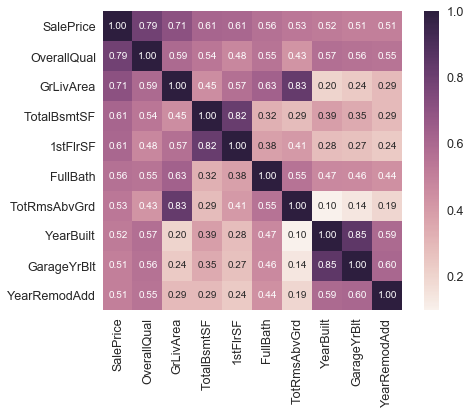

In [47]:
#saleprice correlation matrix
corrmat = data.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, label)[label].index
print(cols.values)
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Plot target

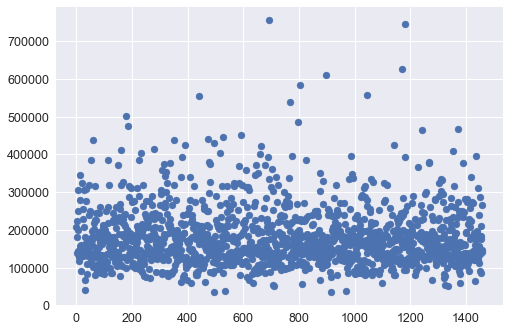

In [52]:
x = np.arange(len(target))
plt.scatter(x, target)
plt.show()

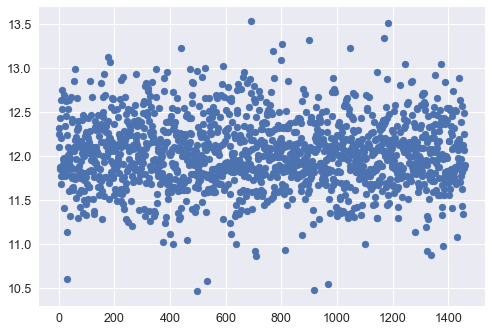

In [54]:
plt.scatter(x, np.log(target))
plt.show()